preliminary analysis
281.28491982653304


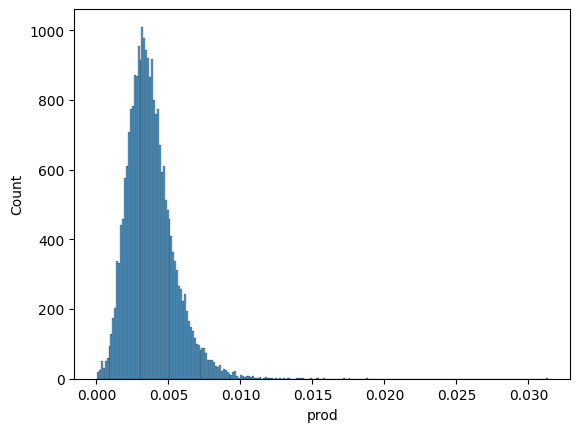

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


print("preliminary analysis")
df = pd.read_excel('data.xlsx')

# Рассчитываем эффективность
df['efficiency'] = (
    df['all_system_fact']-df['break_fact']-df['additional_fact']
) / df['all_system_fact']


# df["cnt_call"] = df["cnt_call"].fillna(0)
# df["cnt_chat"] = df["cnt_chat"].fillna(0)
df["prod"] = (df["cnt_call"]+ df["cnt_chat"])/(df["dlg_time_call"] + df["dlg_time_chat"])
sns.histplot(df["prod"])
print(1/df["prod"].median())

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # Первый квартиль (25%)
    Q3 = df[column].quantile(0.75)  # Третий квартиль (75%)
    IQR = Q3 - Q1                   # Межквартильный размах

    # Определяем границы для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Фильтруем данные, оставляя только значения в пределах границ
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

df['id'] = list(range(len(df)))
moscow_df = df[df["residential_state_nm"].isin(["Москва г", "Иркутская обл", "Тверская обл", "Ярославская обл", "г Санкт-Петербург"])].copy() #самые крупные области и города
df = remove_outliers_iqr(df, 'skill_group_exp')

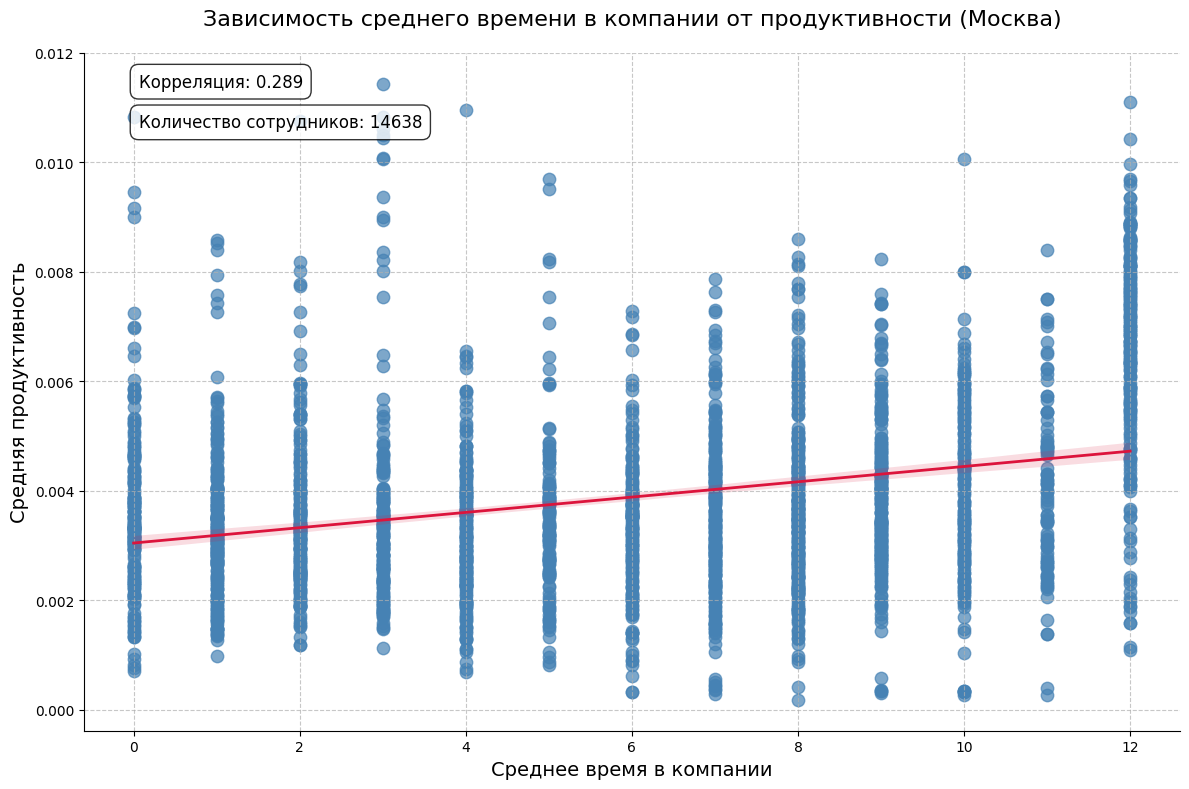

In [32]:
employee_stats = moscow_df.groupby('id').agg({
    'prod': 'median',
    'skill_group_exp': 'median'  # Замените на вашу колонку с временем в компании
}).reset_index()


# Создаем график
plt.figure(figsize=(12, 8))

# Scatter plot с регрессионной линией
sns.regplot(
    data=employee_stats,
    x='skill_group_exp',
    y='prod',  # Замените на вашу колонку
    scatter_kws={
        "alpha": 0.7,
        "s": 80,
        "color": "steelblue"
    },
    line_kws={
        "color": "crimson",
        "lw": 2
    }
)

# Улучшаем внешний вид графика
plt.title('Зависимость среднего времени в компании от продуктивности (Москва)', fontsize=16, pad=20)
plt.ylabel('Средняя продуктивность', fontsize=14)
plt.xlabel('Среднее время в компании', fontsize=14)  # Измените название по необходимости
plt.grid(True, linestyle='--', alpha=0.7)

# Добавляем аннотацию с коэффициентом корреляции
correlation = employee_stats['prod'].corr(employee_stats['skill_group_exp'])
plt.annotate(
    f"Корреляция: {correlation:.3f}",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8)
)

# Добавляем информацию о количестве сотрудников
plt.annotate(
    f"Количество сотрудников: {len(employee_stats)}",
    xy=(0.05, 0.89),
    xycoords="axes fraction",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8)
)

# Настраиваем стиль
sns.despine()
plt.tight_layout()
plt.show()

In [33]:
print(len(moscow_df))
print(moscow_df.head())
print(moscow_df.columns)



14638
   calendar_dt                       id_employee  useful_calls_fact  \
7   2024-12-25  4d2368a248400e3ac8c2f83b7966168a               9303   
14  2024-10-22  0a7b8d5a56610a66970095bdaf772f82                  0   
19  2024-10-22  7f6a08f3072c4f442e020a9aa6b2fdf1                  0   
22  2024-10-22  35de822d3c2f8be1b1f135b7b26e0478                  0   
24  2024-12-25  61e94a0a7f8946d4ec16fff999b2aad2                  4   

    useful_chats_fact  avail_calls_fact  avail_chats_fact  \
7                  83             25498                 0   
14                  0                 0                 0   
19                  0                 0                 0   
22              25840                 0               774   
24              11478                 0              1726   

    avail_chat_call_fact  break_fact  education_fact  additional_fact  ...  \
7                      0        5988               0             2310  ...   
14                     0           0        

Mean Squared Error (MSE): 2.8978111625971075e-06
R-squared (R2): 0.11007361469270205


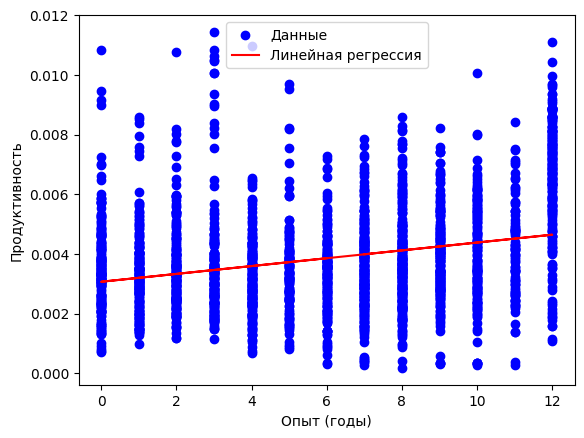

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df_cleaned = moscow_df.dropna(subset=['skill_group_exp', 'prod'])

X = df_cleaned[['skill_group_exp']]  # Признак: опыт
y = df_cleaned['prod']  # Целевая переменная: продуктивность

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели линейной регрессии
model = LinearRegression()

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Визуализация
plt.scatter(X, y, color='blue', label='Данные')
plt.plot(X, model.predict(X), color='red', label='Линейная регрессия')
plt.xlabel('Опыт (годы)')
plt.ylabel('Продуктивность')
plt.legend()
plt.show()

In [ ]:
def plot_eff_by_parameter(parameter_column):
    global grouped_data
    """
    Plot average productivity grouped by values of the given parameter column.
    
    Args:
        parameter_column: The column name to group by
    """
    # Skip if the parameter is 'Продуктивность' itself or if it's not a categorical column
    if parameter_column == 'prod' or moscow_df[parameter_column].nunique() > 200:
        return
    
    # Group by the parameter and calculate mean productivity
    grouped_data = moscow_df.groupby(parameter_column)['prod'].agg(['median', 'count']).reset_index()
    
    # Sort by mean productivity for better visualization
    grouped_data = grouped_data.sort_values('median')    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Create bar plot
    print(parameter_column, grouped_data)
    ax = sns.barplot(x=parameter_column, y='median', data=grouped_data)
    
    # Add count annotations
    # for i, row in enumerate(grouped_data.itertuples()):
    #     ax.text(i, row.mean + 0.01, f"n={row.count}", ha='center', va='bottom', fontsize=8)
    
    # Add labels and title
    plt.title(f'Average prod by {parameter_column}', fontsize=14)
    plt.xlabel(parameter_column, fontsize=12)
    plt.ylabel('Average prod', fontsize=12)
    
    # Rotate x-axis labels if needed
    plt.xticks(fontsize=9, rotation=45, ha='right')
    plt.yticks(fontsize=9)
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [36]:
plot_eff_by_parameter('skill_group_exp')

KeyError: 'mean'

0
                            OLS Regression Results                            
Dep. Variable:                 median   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     10.54
Date:                Sun, 16 Mar 2025   Prob (F-statistic):             0.0118
Time:                        11:54:23   Log-Likelihood:                 57.264
No. Observations:                  10   AIC:                            -110.5
Df Residuals:                       8   BIC:                            -109.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0025      0.000   

c:\Users\Админ\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


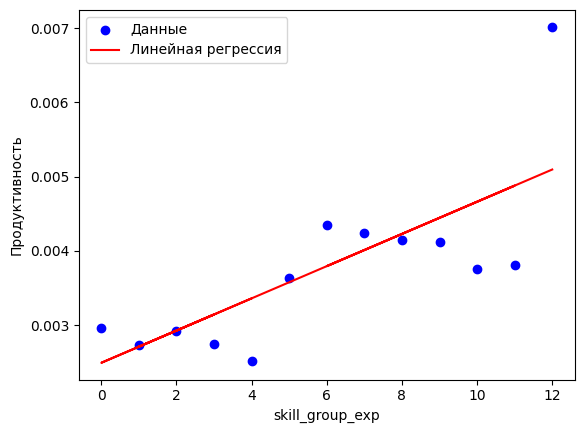

In [ ]:
import statsmodels.api as sm


X = grouped_data[['skill_group_exp']]
y = grouped_data['median']


# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Проверка на NaN в y_train
print(y_train.isnull().sum())


# Добавление константы для модели
X_train_with_const = sm.add_constant(X_train)


# Создание модели
model = sm.OLS(y_train, X_train_with_const).fit()


# Вывод итоговой статистики
print(model.summary())


# Предсказание на тестовых данных
X_test_with_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_with_const)


# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


# Визуализация
plt.scatter(X, y, color='blue', label='Данные')
plt.plot(X, model.predict(sm.add_constant(X)), color='red', label='Линейная регрессия')
plt.xlabel('skill_group_exp')
plt.ylabel('Продуктивность')
plt.legend()
plt.show()

4     0.003774
1     0.003774
3     0.003774
2     0.003774
0     0.003774
5     0.003774
10    0.003774
11    0.003774
9     0.003774
8     0.003774
7     0.003774
6     0.003774
12    0.003774
Name: mean, dtype: float64
NaN values in y_train: 0
                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -8.000
Date:                Sun, 16 Mar 2025   Prob (F-statistic):               1.00
Time:                        11:54:27   Log-Likelihood:                 406.60
No. Observations:                  10   AIC:                            -809.2
Df Residuals:                       8   BIC:                            -808.6
Df Model:                           1                                         
Covariance Type:            nonrobust     

c:\Users\Админ\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
c:\Users\Админ\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


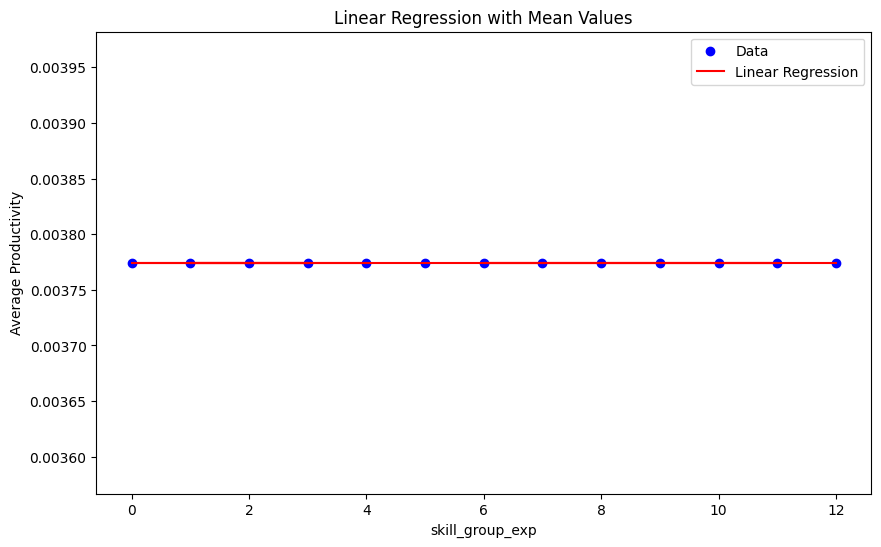

In [ ]:
import statsmodels.api as sm
grouped_data["mean"] = df["prod"].mean()
print(grouped_data["mean"])
# Using mean instead of median
X = grouped_data[['skill_group_exp']]
y = grouped_data['mean']  # Changed from 'median' to 'mean'

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for NaN values
print("NaN values in y_train:", y_train.isnull().sum())

# Add constant term
X_train_with_const = sm.add_constant(X_train)

# Create and fit the model
model = sm.OLS(y_train, X_train_with_const).fit()

# Print model summary
print(model.summary())

# Predictions on test data
X_test_with_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_with_const)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, model.predict(sm.add_constant(X)), color='red', label='Linear Regression')
plt.xlabel('skill_group_exp')
plt.ylabel('Average Productivity')
plt.title('Linear Regression with Mean Values')
plt.legend()
plt.show()


c:\Users\Админ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Админ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
c:\Users\Админ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\Админ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
c:\Users\Админ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does n

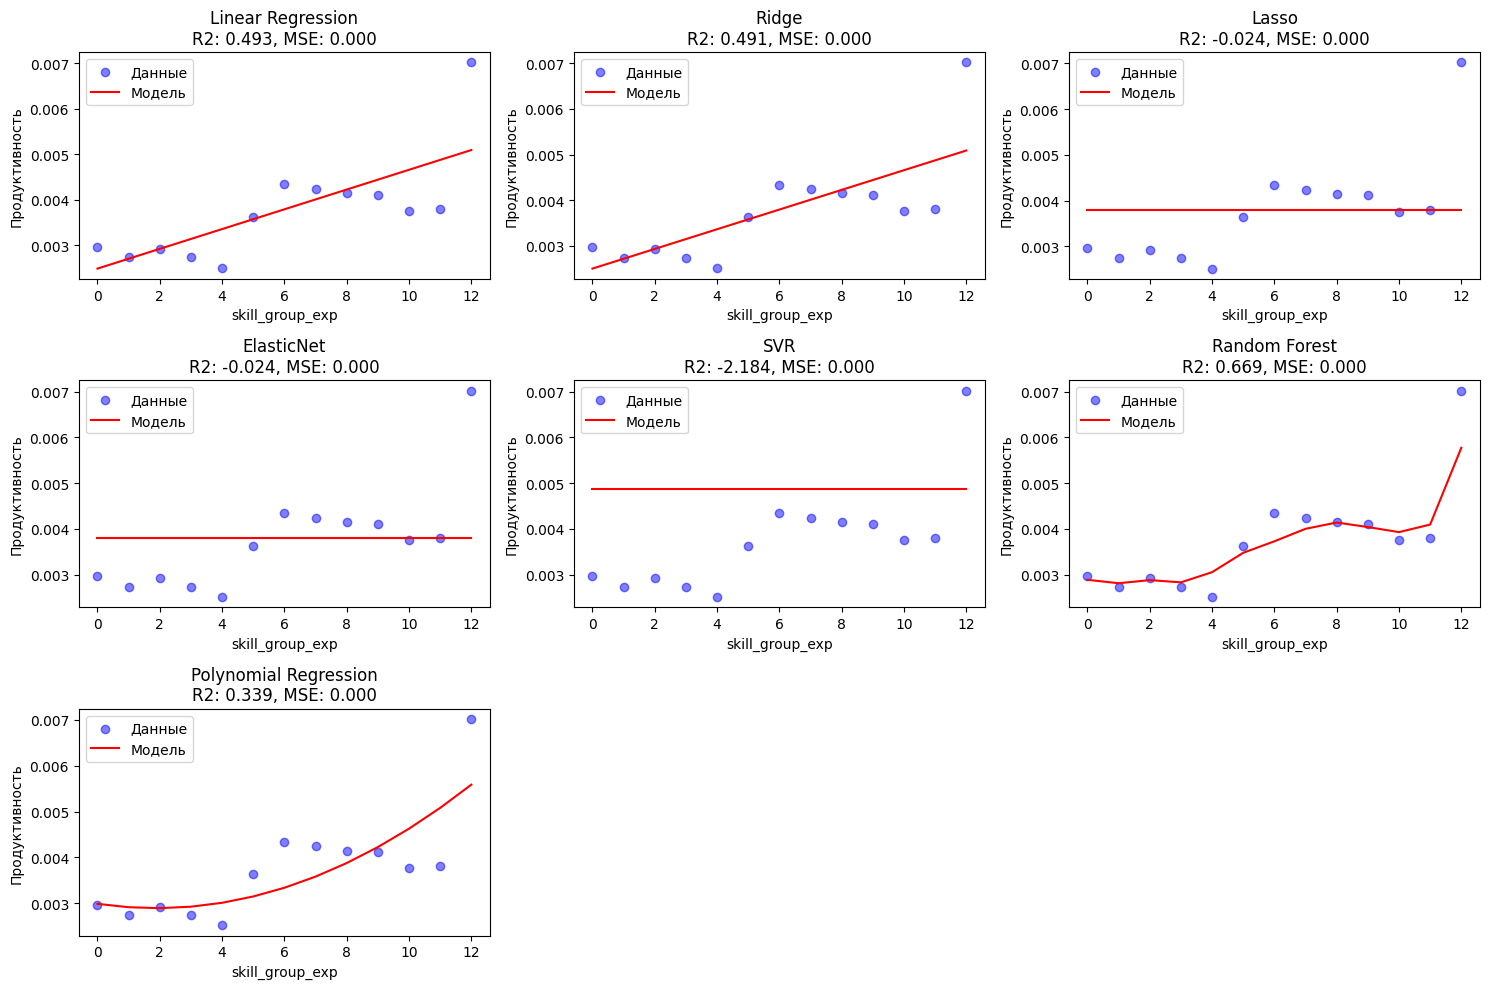

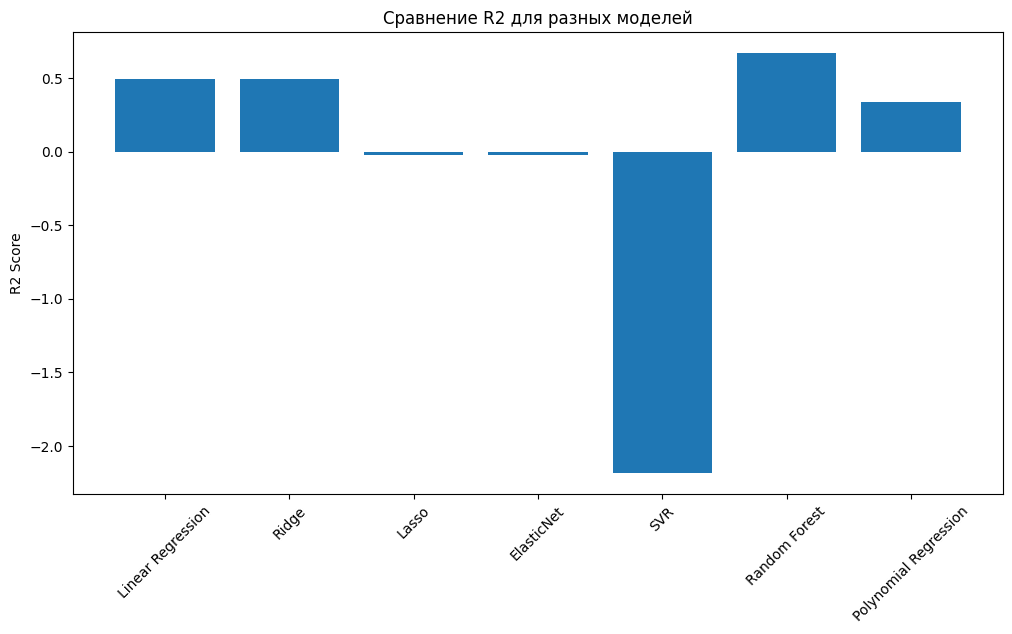


Linear Regression:
R2 Score: 0.493
MSE: 0.000
p-value: 0.395692

Ridge:
R2 Score: 0.491
MSE: 0.000
p-value: 0.395692

Lasso:
R2 Score: -0.024
MSE: 0.000
p-value: 0.395692

ElasticNet:
R2 Score: -0.024
MSE: 0.000
p-value: 0.395692

SVR:
R2 Score: -2.184
MSE: 0.000
p-value: 0.395692

Random Forest:
R2 Score: 0.714
MSE: 0.000
p-value: 0.395692

Polynomial Regression:
R2 Score: 0.339
MSE: 0.000
p-value: 0.395692

Linear Regression:
R2 Score: 0.493
MSE: 0.000

Ridge:
R2 Score: 0.491
MSE: 0.000

Lasso:
R2 Score: -0.024
MSE: 0.000

ElasticNet:
R2 Score: -0.024
MSE: 0.000

SVR:
R2 Score: -2.184
MSE: 0.000

Random Forest:
R2 Score: 0.714
MSE: 0.000

Polynomial Regression:
R2 Score: 0.339
MSE: 0.000


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

from sklearn.pipeline import Pipeline

def make_pipeline(*steps):
    """
    Creates a Pipeline of transforms with a final estimator.
    
    Parameters:
    steps : list of (string, estimator) tuples
        List of (name, transform) tuples that are chained in sequential order.
    
    Returns:
    Pipeline : object
    """
    return Pipeline([(f"step{i}", step) for i, step in enumerate(steps, 1)])


# Подготовка данных
X = grouped_data[['skill_group_exp']]
y = grouped_data['median']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Список моделей
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'SVR': SVR(kernel='rbf'),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'Polynomial Regression': make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
}

# Обучение и оценка моделей
results = {}
plt.figure(figsize=(15, 10))

for i, (name, model) in enumerate(models.items()):
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказания
    y_pred = model.predict(X_test)
    
    # Метрики
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {'R2': r2, 'MSE': mse}
    
    # Визуализация
    plt.subplot(3, 3, i+1)
    plt.scatter(X, y, color='blue', alpha=0.5, label='Данные')
    
    # Сортировка для плавной линии
    X_sorted = np.sort(X.values, axis=0)
    y_pred_line = model.predict(X_sorted)
    
    plt.plot(X_sorted, y_pred_line, color='red', label='Модель')
    plt.title(f'{name}\nR2: {r2:.3f}, MSE: {mse:.3f}')
    plt.xlabel('skill_group_exp')
    plt.ylabel('Продуктивность')
    plt.legend()

plt.tight_layout()
plt.show()

# Сравнительная визуализация R2 scores
plt.figure(figsize=(12, 6))
r2_scores = [results[model]['R2'] for model in results]
plt.bar(results.keys(), r2_scores)
plt.xticks(rotation=45)
plt.title('Сравнение R2 для разных моделей')
plt.ylabel('R2 Score')
plt.show()

from scipy import stats

def calculate_regression_pvalue(X, y, y_pred):
    # Calculate correlation coefficient
    correlation_matrix = np.corrcoef(X.squeeze(), y)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    
    # Calculate t-statistic and p-value
    n = len(X)
    t_stat = correlation_xy * np.sqrt((n-2)/(1-r_squared))
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n-2))
    
    return p_value

# Modify the results dictionary to include p-values
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    p_value = calculate_regression_pvalue(X_test, y_test, y_pred)
    
    results[name] = {
        'R2': r2,
        'MSE': mse,
        'p_value': p_value
    }

# Updated results output
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"R2 Score: {metrics['R2']:.3f}")
    print(f"MSE: {metrics['MSE']:.3f}")
    print(f"p-value: {metrics['p_value']:.6f}")


# Вывод результатов
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"R2 Score: {metrics['R2']:.3f}")
    print(f"MSE: {metrics['MSE']:.3f}")


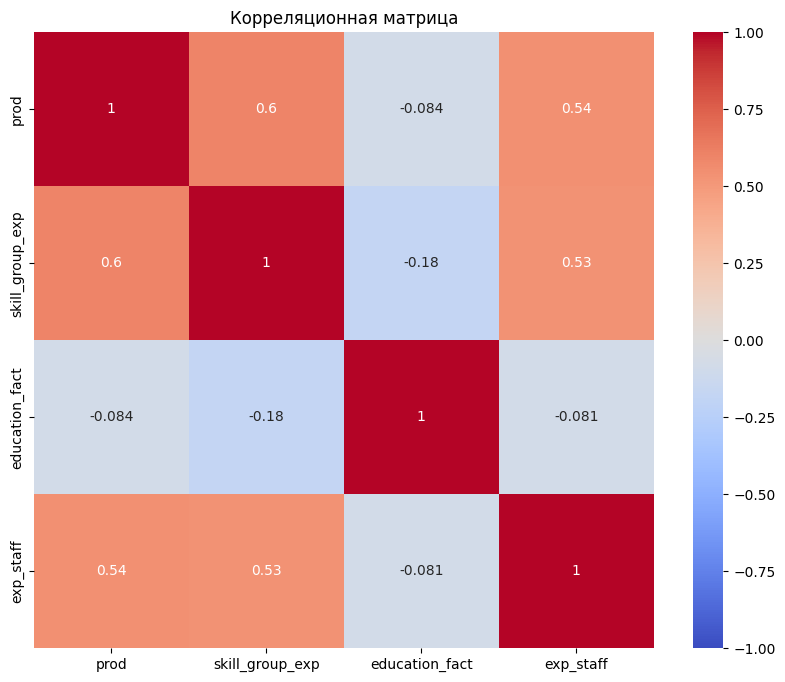

In [ ]:
# Создаем корреляционную матрицу
correlation_matrix = df_cleaned[['prod', 'skill_group_exp', 'education_fact', 'exp_staff']].corr()

# Визуализируем корреляционную матрицу с помощью heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица')
plt.show()



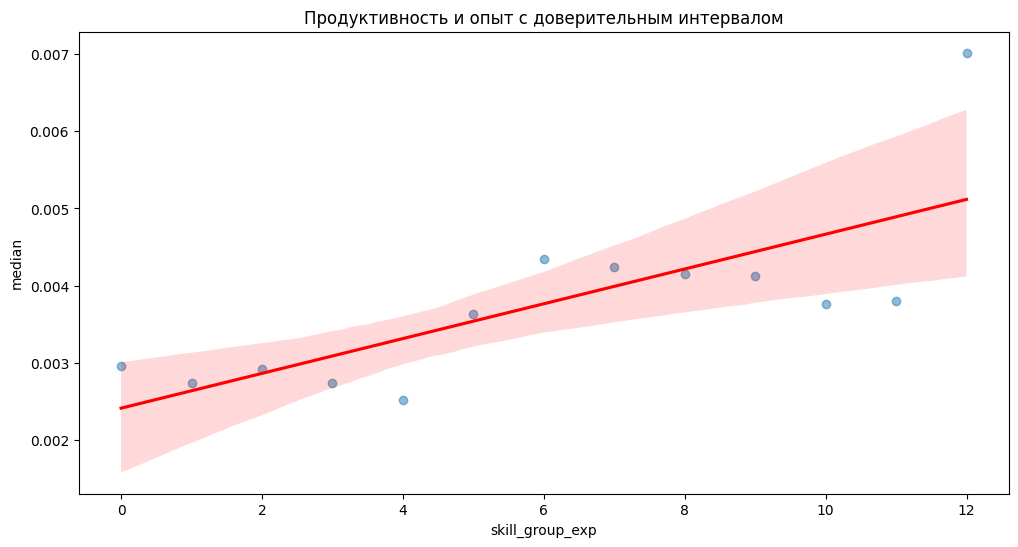

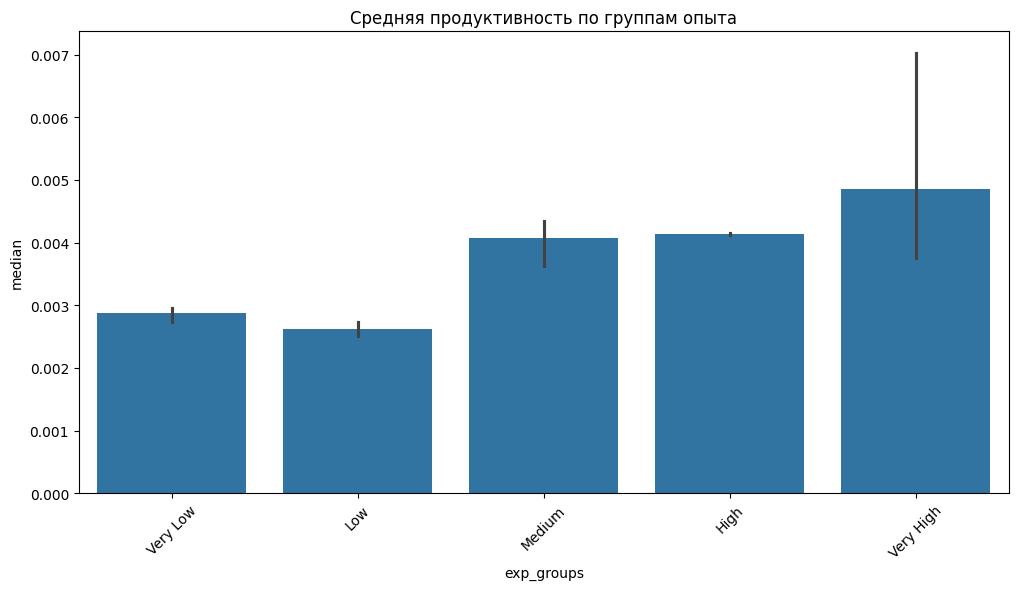

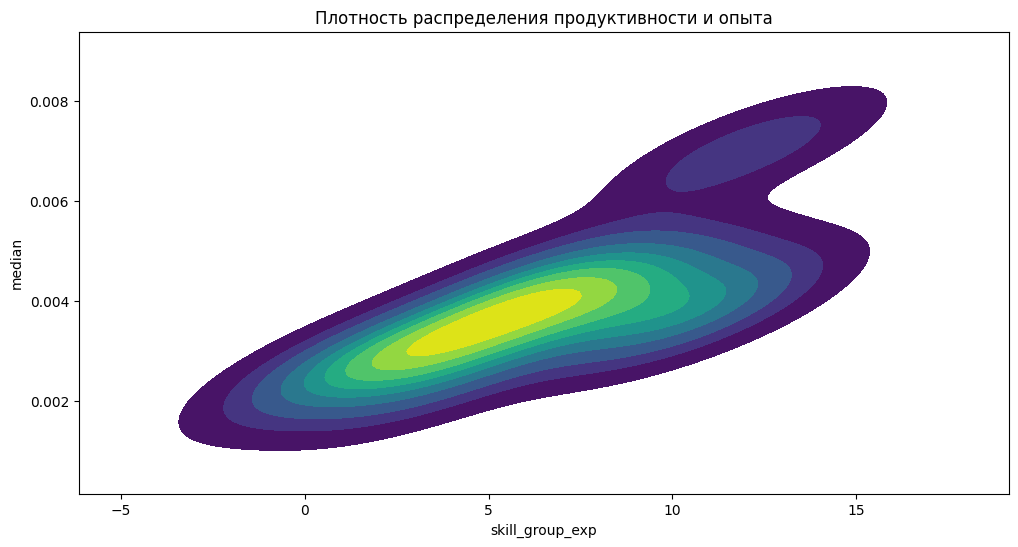

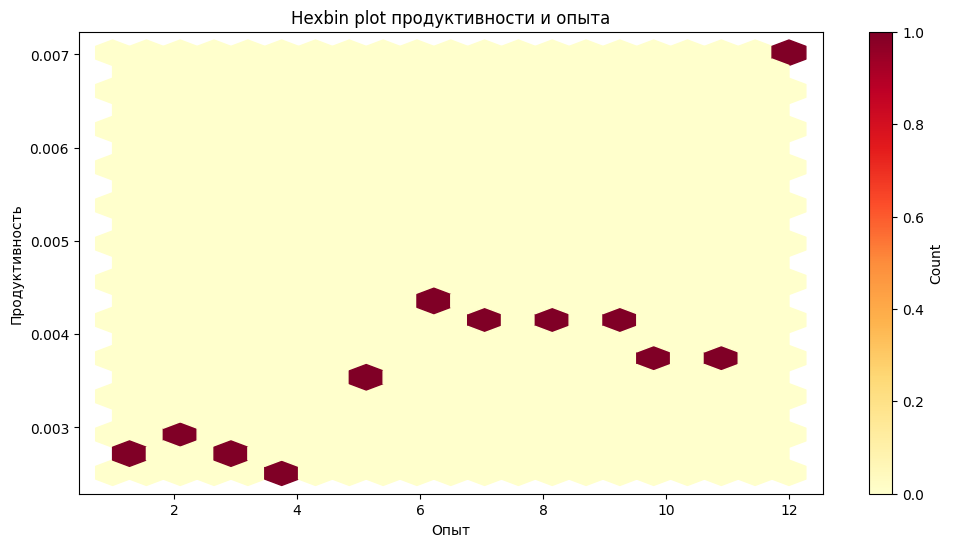

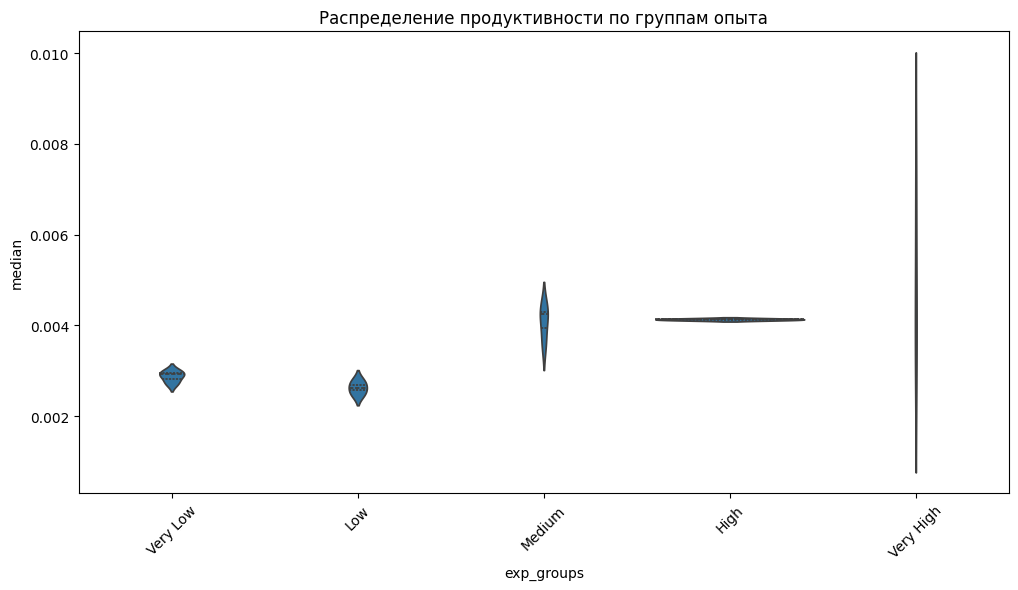

In [ ]:
# 1. Enhanced scatter plot with trend confidence
plt.figure(figsize=(12, 6))
sns.regplot(data=grouped_data, x='skill_group_exp', y='median', 
            scatter_kws={'alpha':0.5}, 
            line_kws={'color': 'red'})
plt.title('Продуктивность и опыт с доверительным интервалом')
plt.show()

# 2. Grouped bar chart
grouped_data['exp_groups'] = pd.qcut(grouped_data['skill_group_exp'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_data, x='exp_groups', y='median')
plt.title('Средняя продуктивность по группам опыта')
plt.xticks(rotation=45)
plt.show()

# 3. KDE plot
plt.figure(figsize=(12, 6))
grouped_data['skill_group_exp'] = grouped_data[grouped_data["skill_group_exp"] > 0]['skill_group_exp']
sns.kdeplot(data=grouped_data, x='skill_group_exp', y='median', cmap='viridis', fill=True)
plt.title('Плотность распределения продуктивности и опыта')
plt.show()

# 4. Hexbin plot
plt.figure(figsize=(12, 6))
plt.hexbin(grouped_data['skill_group_exp'], grouped_data['median'], gridsize=20, cmap='YlOrRd')
plt.colorbar(label='Count')
plt.title('Hexbin plot продуктивности и опыта')
plt.xlabel('Опыт')
plt.ylabel('Продуктивность')
plt.show()

# 5. Violin plot with quartiles
plt.figure(figsize=(12, 6))
sns.violinplot(data=grouped_data, x='exp_groups', y='median', inner='quartile')
plt.title('Распределение продуктивности по группам опыта')
plt.xticks(rotation=45)
plt.show()


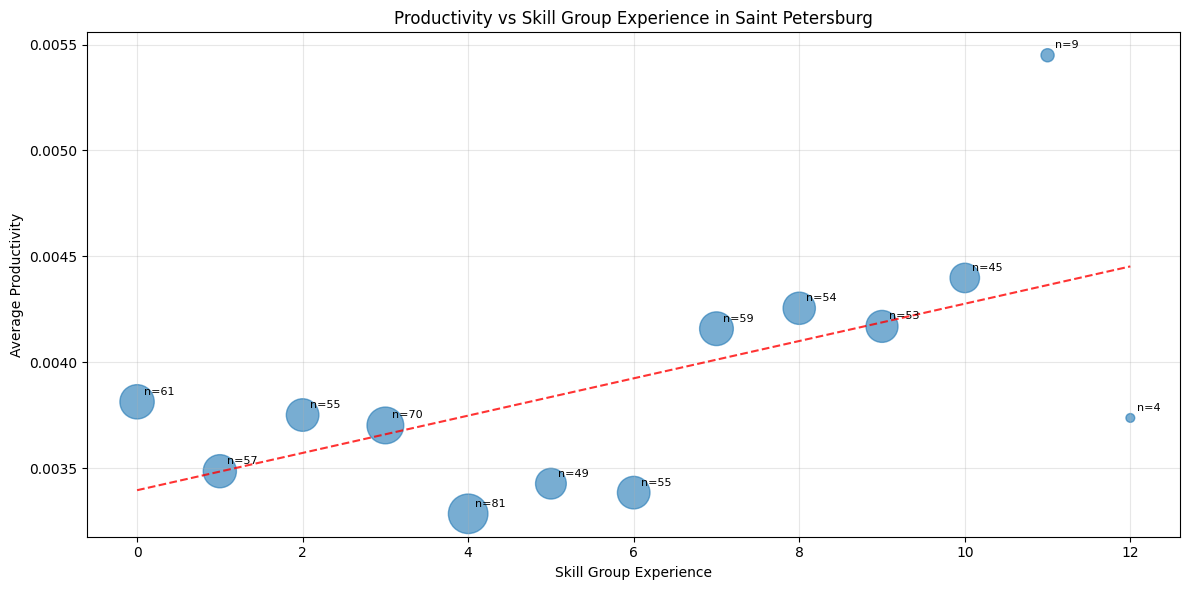

Linear Regression Analysis:
--------------------------
Correlation coefficient: 0.591
Correlation p-value: 0.033467

Regression Statistics:
R-squared: 0.349
Adjusted R-squared: 0.290
P-value: 0.033467
Coefficient: 0.000
Intercept: 0.003

Detailed Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 median   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     5.900
Date:                Sun, 16 Mar 2025   Prob (F-statistic):             0.0335
Time:                        12:05:15   Log-Likelihood:                 81.733
No. Observations:                  13   AIC:                            -159.5
Df Residuals:                      11   BIC:                            -158.3
Df Model:                           1                                         
Covariance Type:           

C:\Users\Админ\AppData\Local\Temp\ipykernel_3688\1180243148.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"P-value: {model.pvalues[1]:.6f}")
C:\Users\Админ\AppData\Local\Temp\ipykernel_3688\1180243148.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coefficient: {model.params[1]:.3f}")
C:\Users\Админ\AppData\Local\Temp\ipykernel_3688\1180243148.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"In

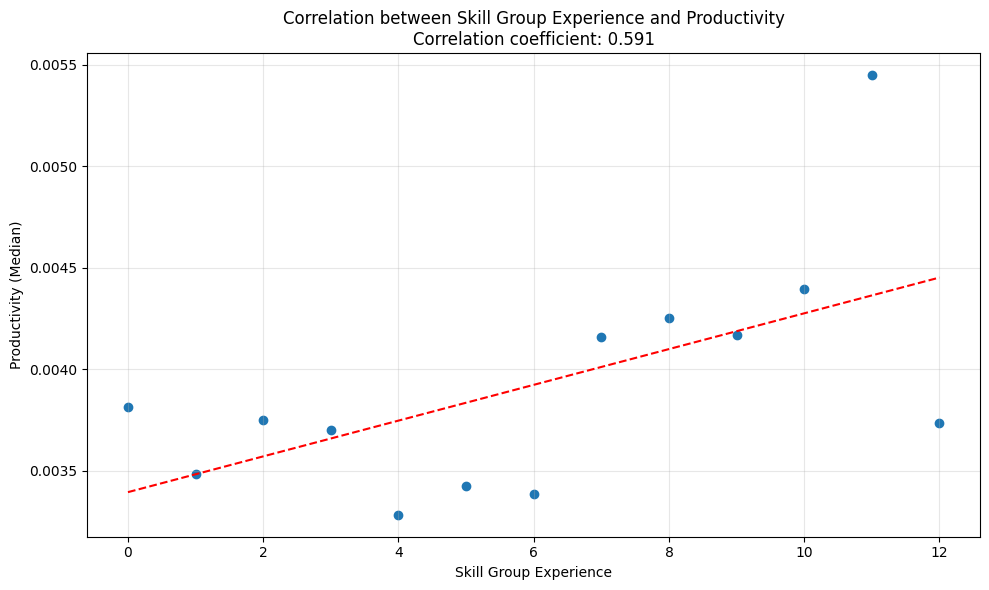

Correlation coefficient: 0.591

Correlation matrix:
                 Skill Group Exp  Productivity
Skill Group Exp         1.000000      0.590863
Productivity            0.590863      1.000000


In [ ]:
# Filter data for Saint Petersburg
spb_data = df[df['residential_city_nm'] == 'г Санкт-Петербург']


# Group by skill_group_exp and calculate mean productivity
spb_grouped = spb_data.groupby('skill_group_exp')['prod'].agg(['median', 'count']).reset_index()


# Create the plot
plt.figure(figsize=(12, 6))


# Scatter plot with point sizes proportional to count
plt.scatter(spb_grouped['skill_group_exp'],spb_grouped['median'],s=spb_grouped['count']*10,alpha=0.6)


# Add trend line
z = np.polyfit(spb_grouped['skill_group_exp'], spb_grouped['median'], 1)
p = np.poly1d(z)
plt.plot(spb_grouped['skill_group_exp'],p(spb_grouped['skill_group_exp']),"r--",alpha=0.8)


# Customize the plot
plt.title('Productivity vs Skill Group Experience in Saint Petersburg')
plt.xlabel('Skill Group Experience')
plt.ylabel('Average Productivity')
plt.grid(True, alpha=0.3)


# Add count annotations
for i, row in spb_grouped.iterrows():
    plt.annotate(f'n={int(row["count"])}',
                 (row['skill_group_exp'], row['median']),
                 xytext=(5, 5),
                 textcoords='offset points',
                 fontsize=8)


plt.tight_layout()
plt.show()

import statsmodels.api as sm
from scipy import stats

# Calculate Pearson correlation
correlation, corr_pvalue = stats.pearsonr(spb_grouped['skill_group_exp'], spb_grouped['median'])

# Prepare data for regression
X = spb_grouped['skill_group_exp']
y = spb_grouped['median']
X_const = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X_const).fit()

# Print results
print("Linear Regression Analysis:")
print("--------------------------")
print(f"Correlation coefficient: {correlation:.3f}")
print(f"Correlation p-value: {corr_pvalue:.6f}")
print("\nRegression Statistics:")
print(f"R-squared: {model.rsquared:.3f}")
print(f"Adjusted R-squared: {model.rsquared_adj:.3f}")
print(f"P-value: {model.pvalues[1]:.6f}")
print(f"Coefficient: {model.params[1]:.3f}")
print(f"Intercept: {model.params[0]:.3f}")

# Print detailed summary
print("\nDetailed Model Summary:")
print(model.summary())

# Calculate and visualize correlation
plt.figure(figsize=(10, 6))
plt.scatter(spb_grouped['skill_group_exp'], spb_grouped['median'])

# Add correlation line
correlation_matrix = np.corrcoef(spb_grouped['skill_group_exp'], spb_grouped['median'])
correlation = correlation_matrix[0,1]

plt.title(f'Correlation between Skill Group Experience and Productivity\nCorrelation coefficient: {correlation:.3f}')
plt.xlabel('Skill Group Experience')
plt.ylabel('Productivity (Median)')

# Add trend line
z = np.polyfit(spb_grouped['skill_group_exp'], spb_grouped['median'], 1)
p = np.poly1d(z)
plt.plot(spb_grouped['skill_group_exp'], p(spb_grouped['skill_group_exp']), "r--")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed correlation statistics
print(f"Correlation coefficient: {correlation:.3f}")
print("\nCorrelation matrix:")
print(pd.DataFrame(correlation_matrix, 
                  columns=['Skill Group Exp', 'Productivity'],
                  index=['Skill Group Exp', 'Productivity']))





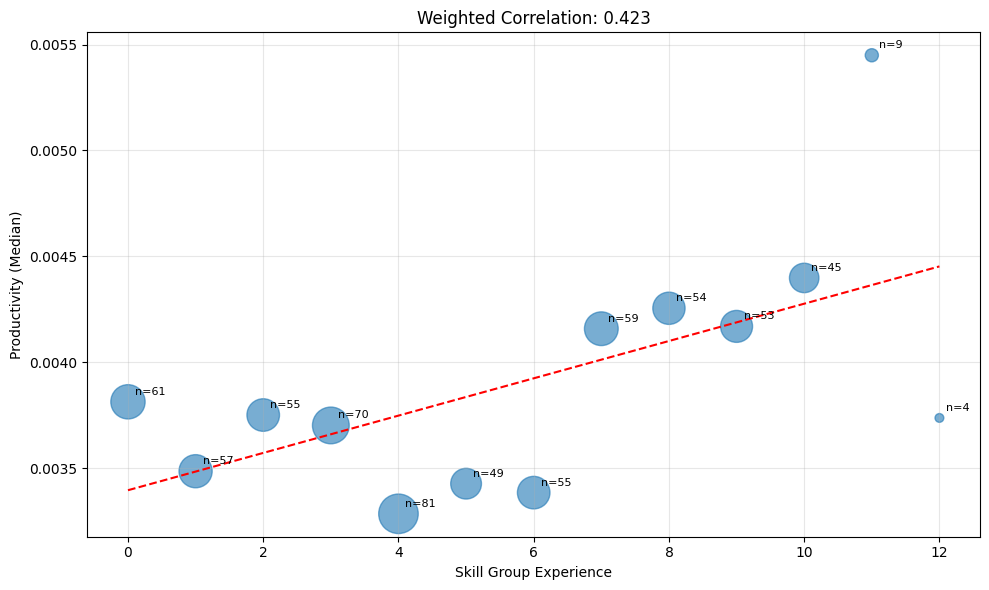

Weighted correlation coefficient: 0.423


In [ ]:
# Calculate weighted correlation
weights = spb_grouped['count']
weighted_correlation = np.cov(spb_grouped['skill_group_exp'], spb_grouped['median'], 
                            aweights=weights)[0,1] / (np.std(spb_grouped['skill_group_exp']) * np.std(spb_grouped['median']))

# Visualization with weighted correlation
plt.figure(figsize=(10, 6))
plt.scatter(spb_grouped['skill_group_exp'], spb_grouped['median'], 
           s=weights*10, alpha=0.6)

# Add trend line
z = np.polyfit(spb_grouped['skill_group_exp'], spb_grouped['median'], 1)
p = np.poly1d(z)
plt.plot(spb_grouped['skill_group_exp'], p(spb_grouped['skill_group_exp']), "r--")

plt.title(f'Weighted Correlation: {weighted_correlation:.3f}')
plt.xlabel('Skill Group Experience')
plt.ylabel('Productivity (Median)')
plt.grid(True, alpha=0.3)

# Add sample size annotations
for i, row in spb_grouped.iterrows():
    plt.annotate(f'n={int(row["count"])}', 
                (row['skill_group_exp'], row['median']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8)

plt.tight_layout()
plt.show()

print(f"Weighted correlation coefficient: {weighted_correlation:.3f}")


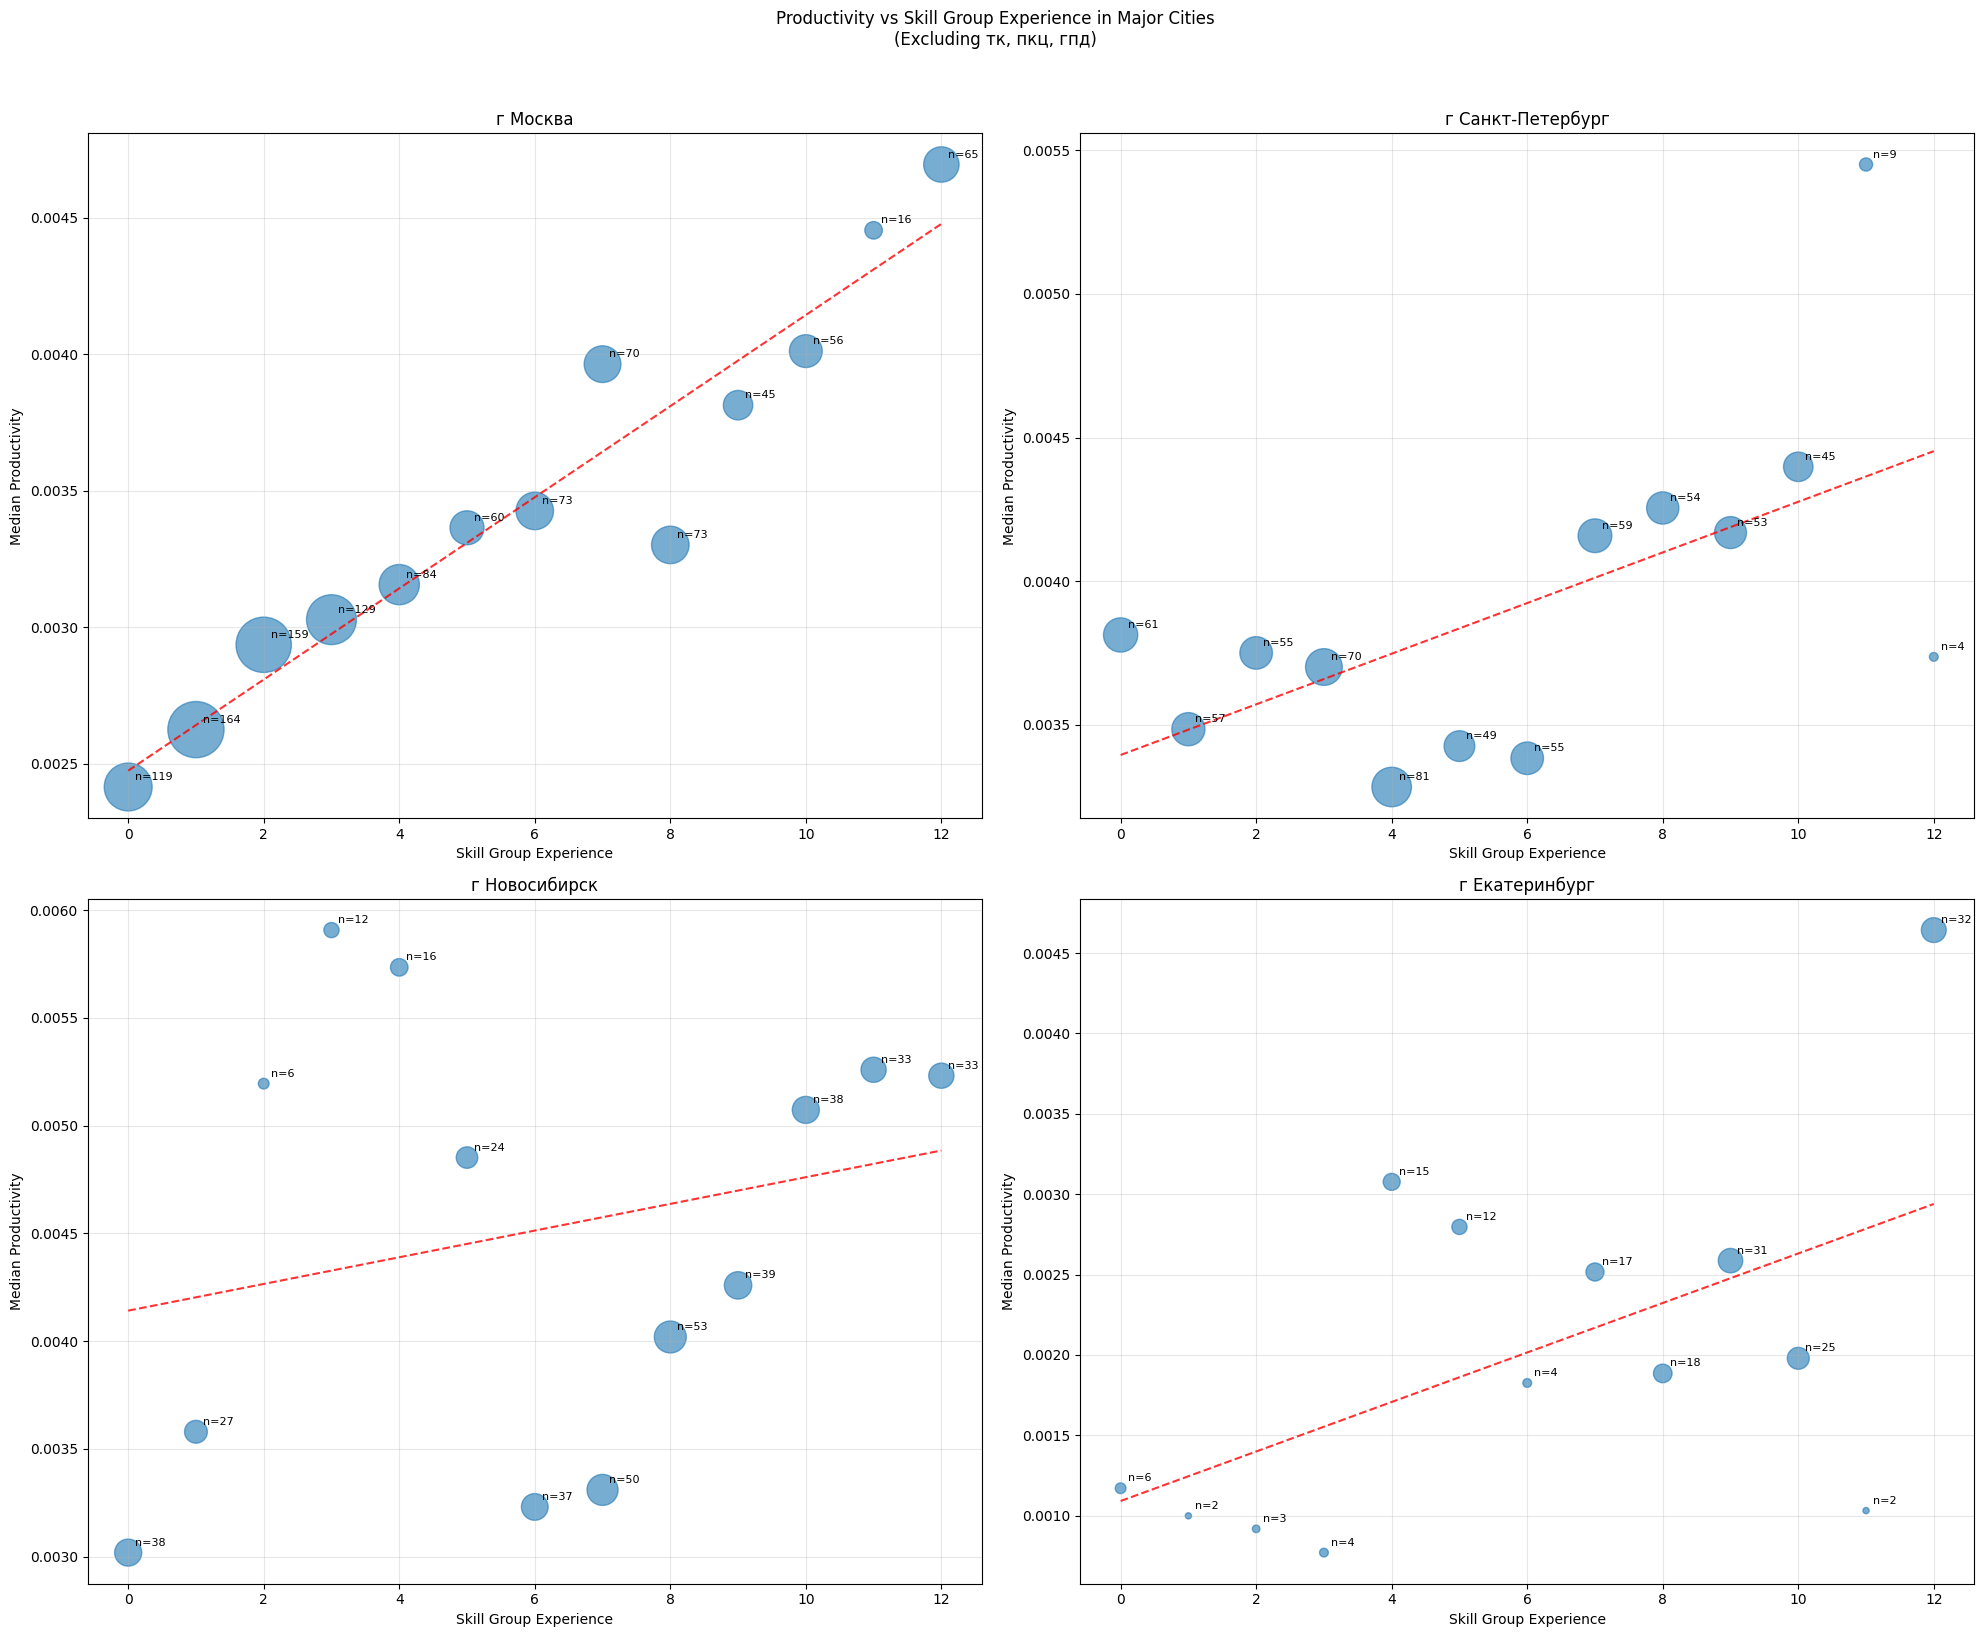

In [46]:
# Define major cities
major_cities = ['г Москва', 'г Санкт-Петербург', 'г Новосибирск', 'г Екатеринбург']

# Filter data
filtered_data = df[df['emp_type'].isin(['ТК', 'ПКЦ', 'ГПД'])]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for idx, city in enumerate(major_cities):
    # Filter data for each city
    city_data = filtered_data[filtered_data['residential_city_nm'] == city]
    city_grouped = city_data.groupby('skill_group_exp')['prod'].agg(['median', 'count']).reset_index()
    
    # Create scatter plot
    axes[idx].scatter(city_grouped['skill_group_exp'], 
                     city_grouped['median'],
                     s=city_grouped['count']*10,
                     alpha=0.6)
    
    # Add trend line
    z = np.polyfit(city_grouped['skill_group_exp'], city_grouped['median'], 1)
    p = np.poly1d(z)
    axes[idx].plot(city_grouped['skill_group_exp'],
                  p(city_grouped['skill_group_exp']),
                  "r--",
                  alpha=0.8)
    
    # Add annotations
    for _, row in city_grouped.iterrows():
        axes[idx].annotate(f'n={int(row["count"])}',
                          (row['skill_group_exp'], row['median']),
                          xytext=(5, 5),
                          textcoords='offset points',
                          fontsize=8)
    
    # Customize plot
    axes[idx].set_title(f'{city}')
    axes[idx].set_xlabel('Skill Group Experience')
    axes[idx].set_ylabel('Median Productivity')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Productivity vs Skill Group Experience in Major Cities\n(Excluding тк, пкц, гпд)', y=1.02)
plt.tight_layout()
plt.show()


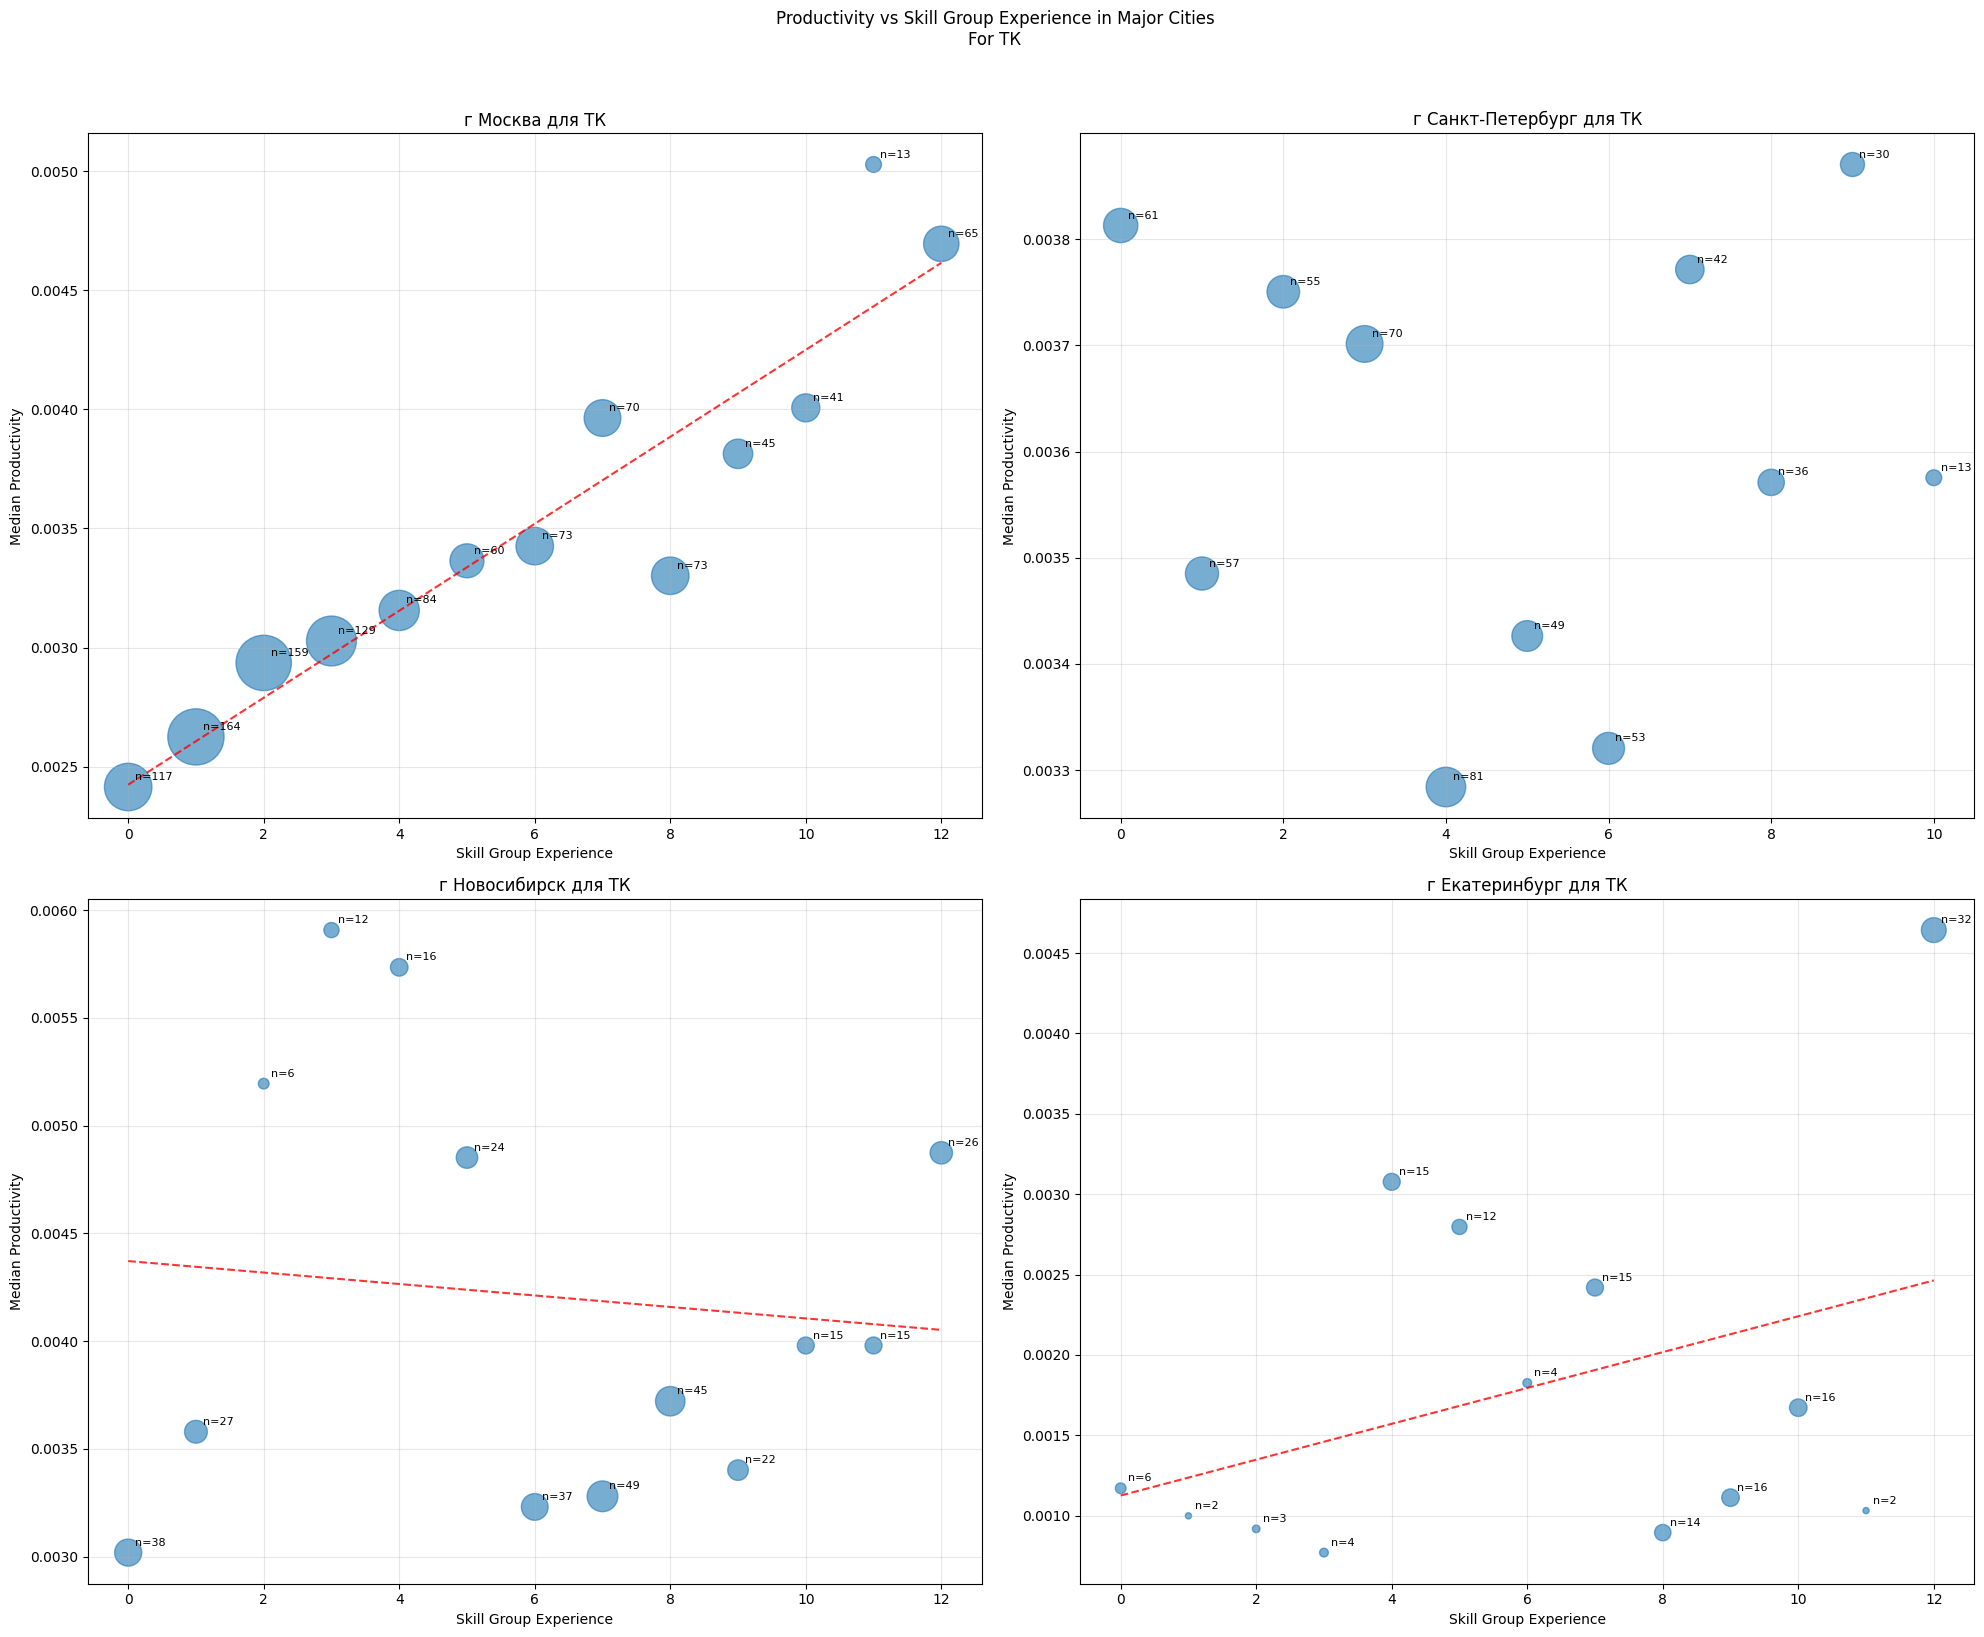

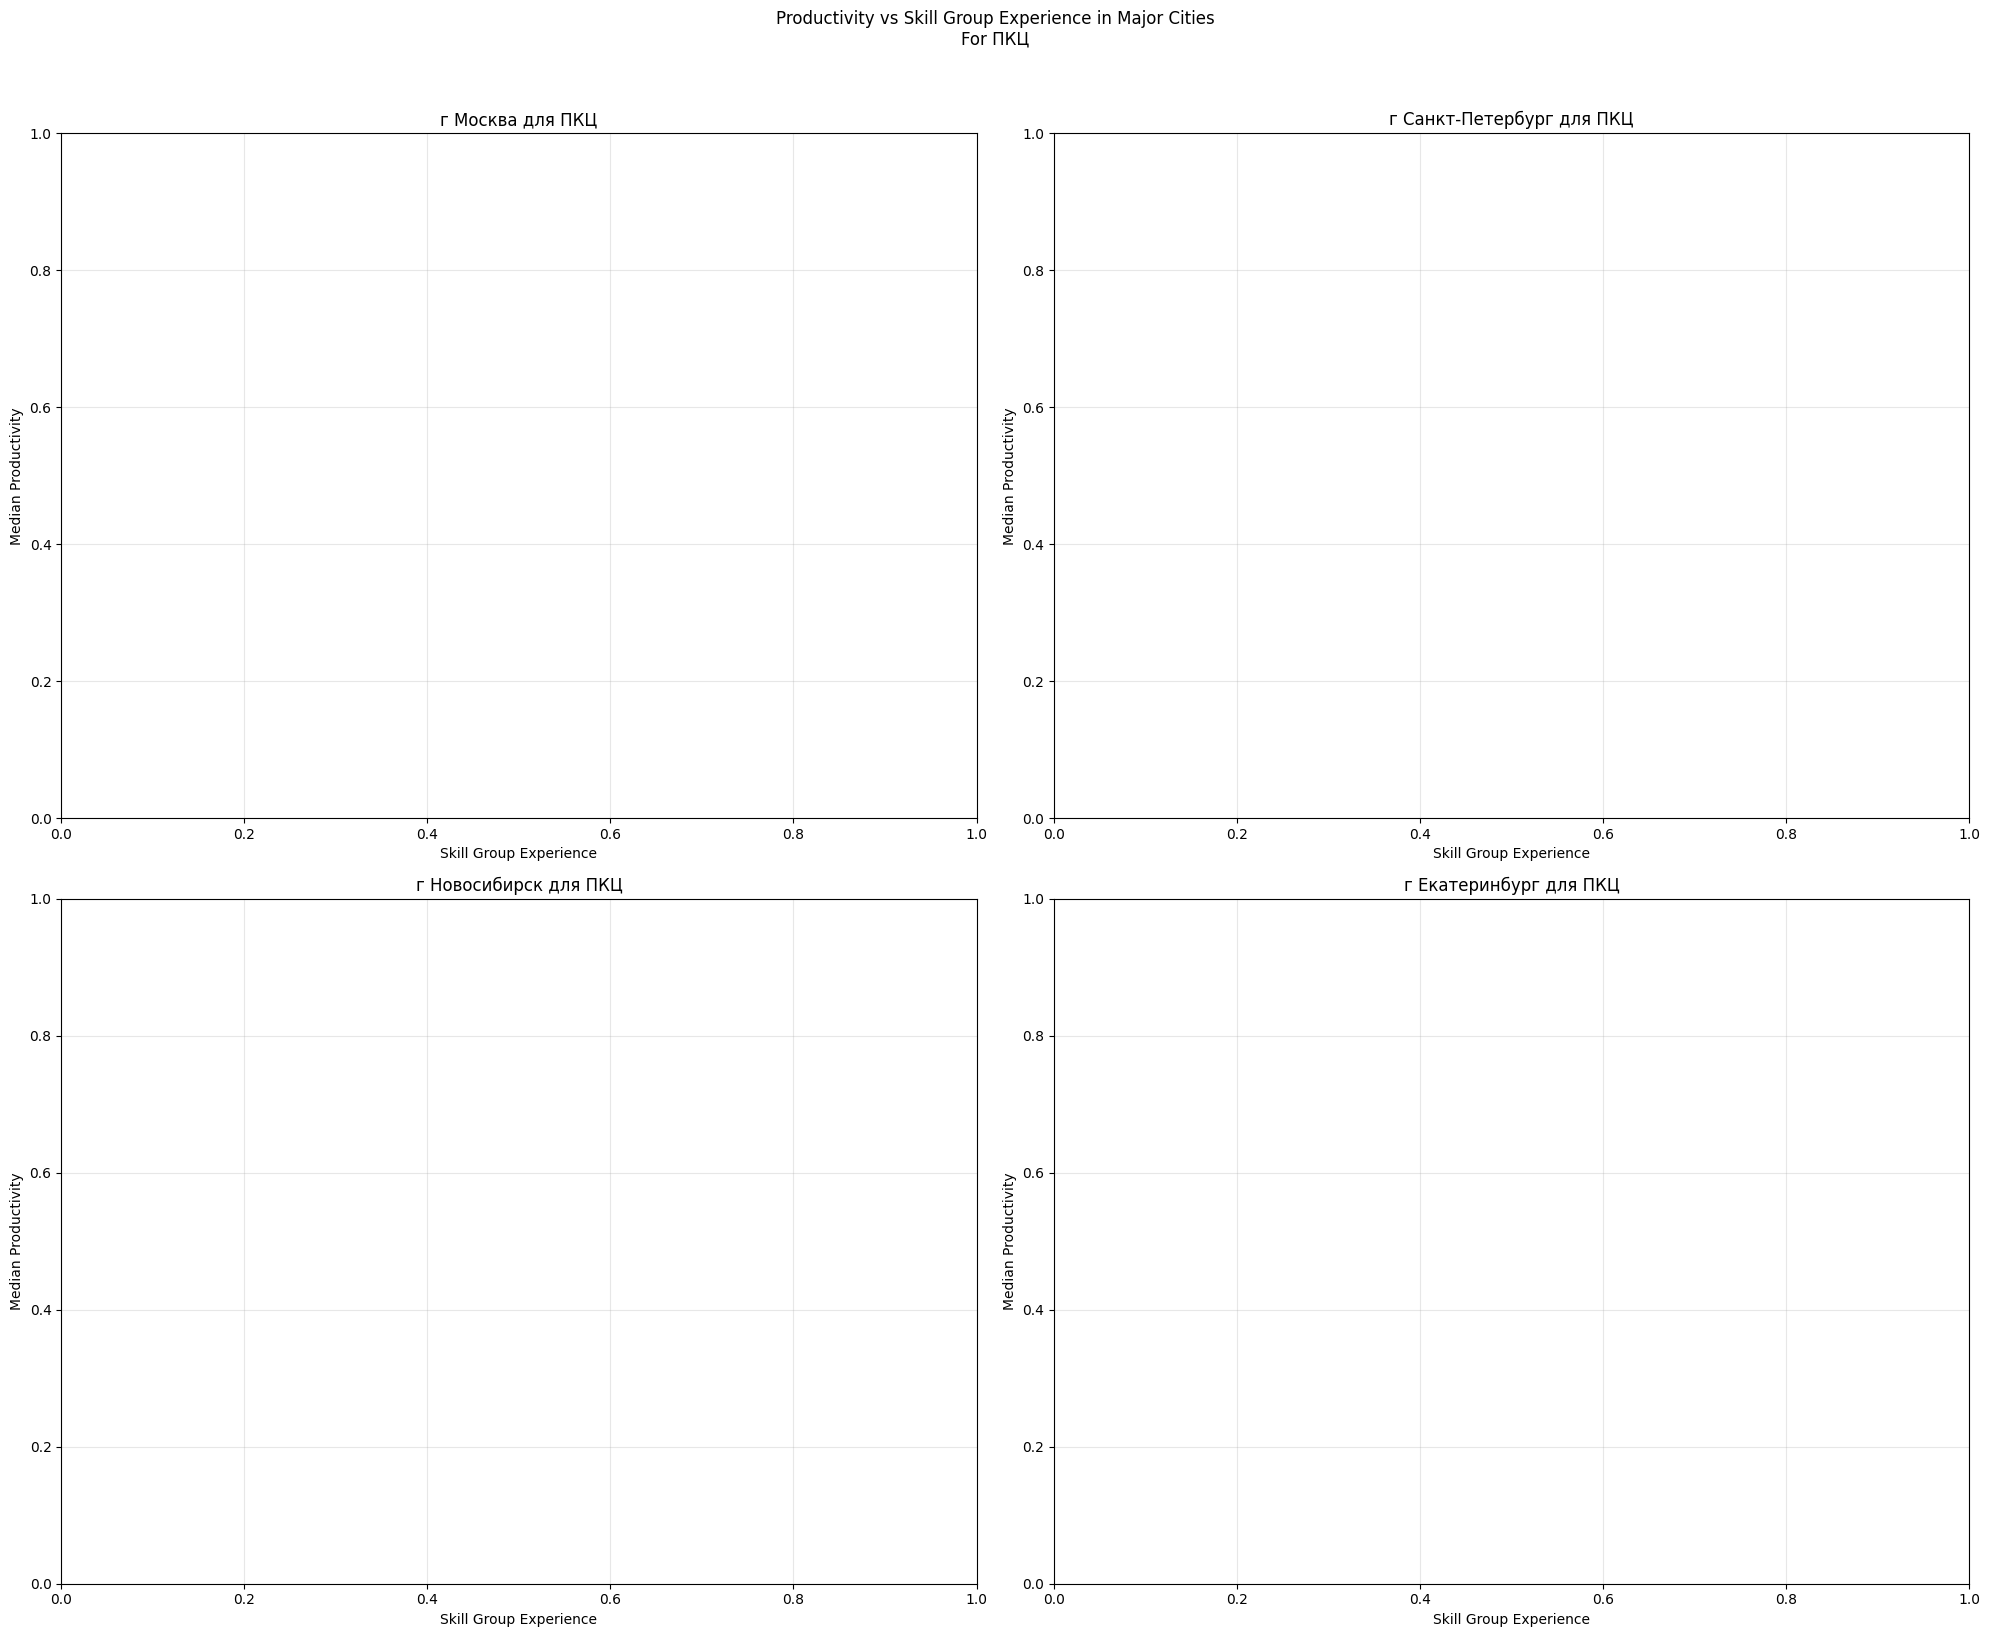

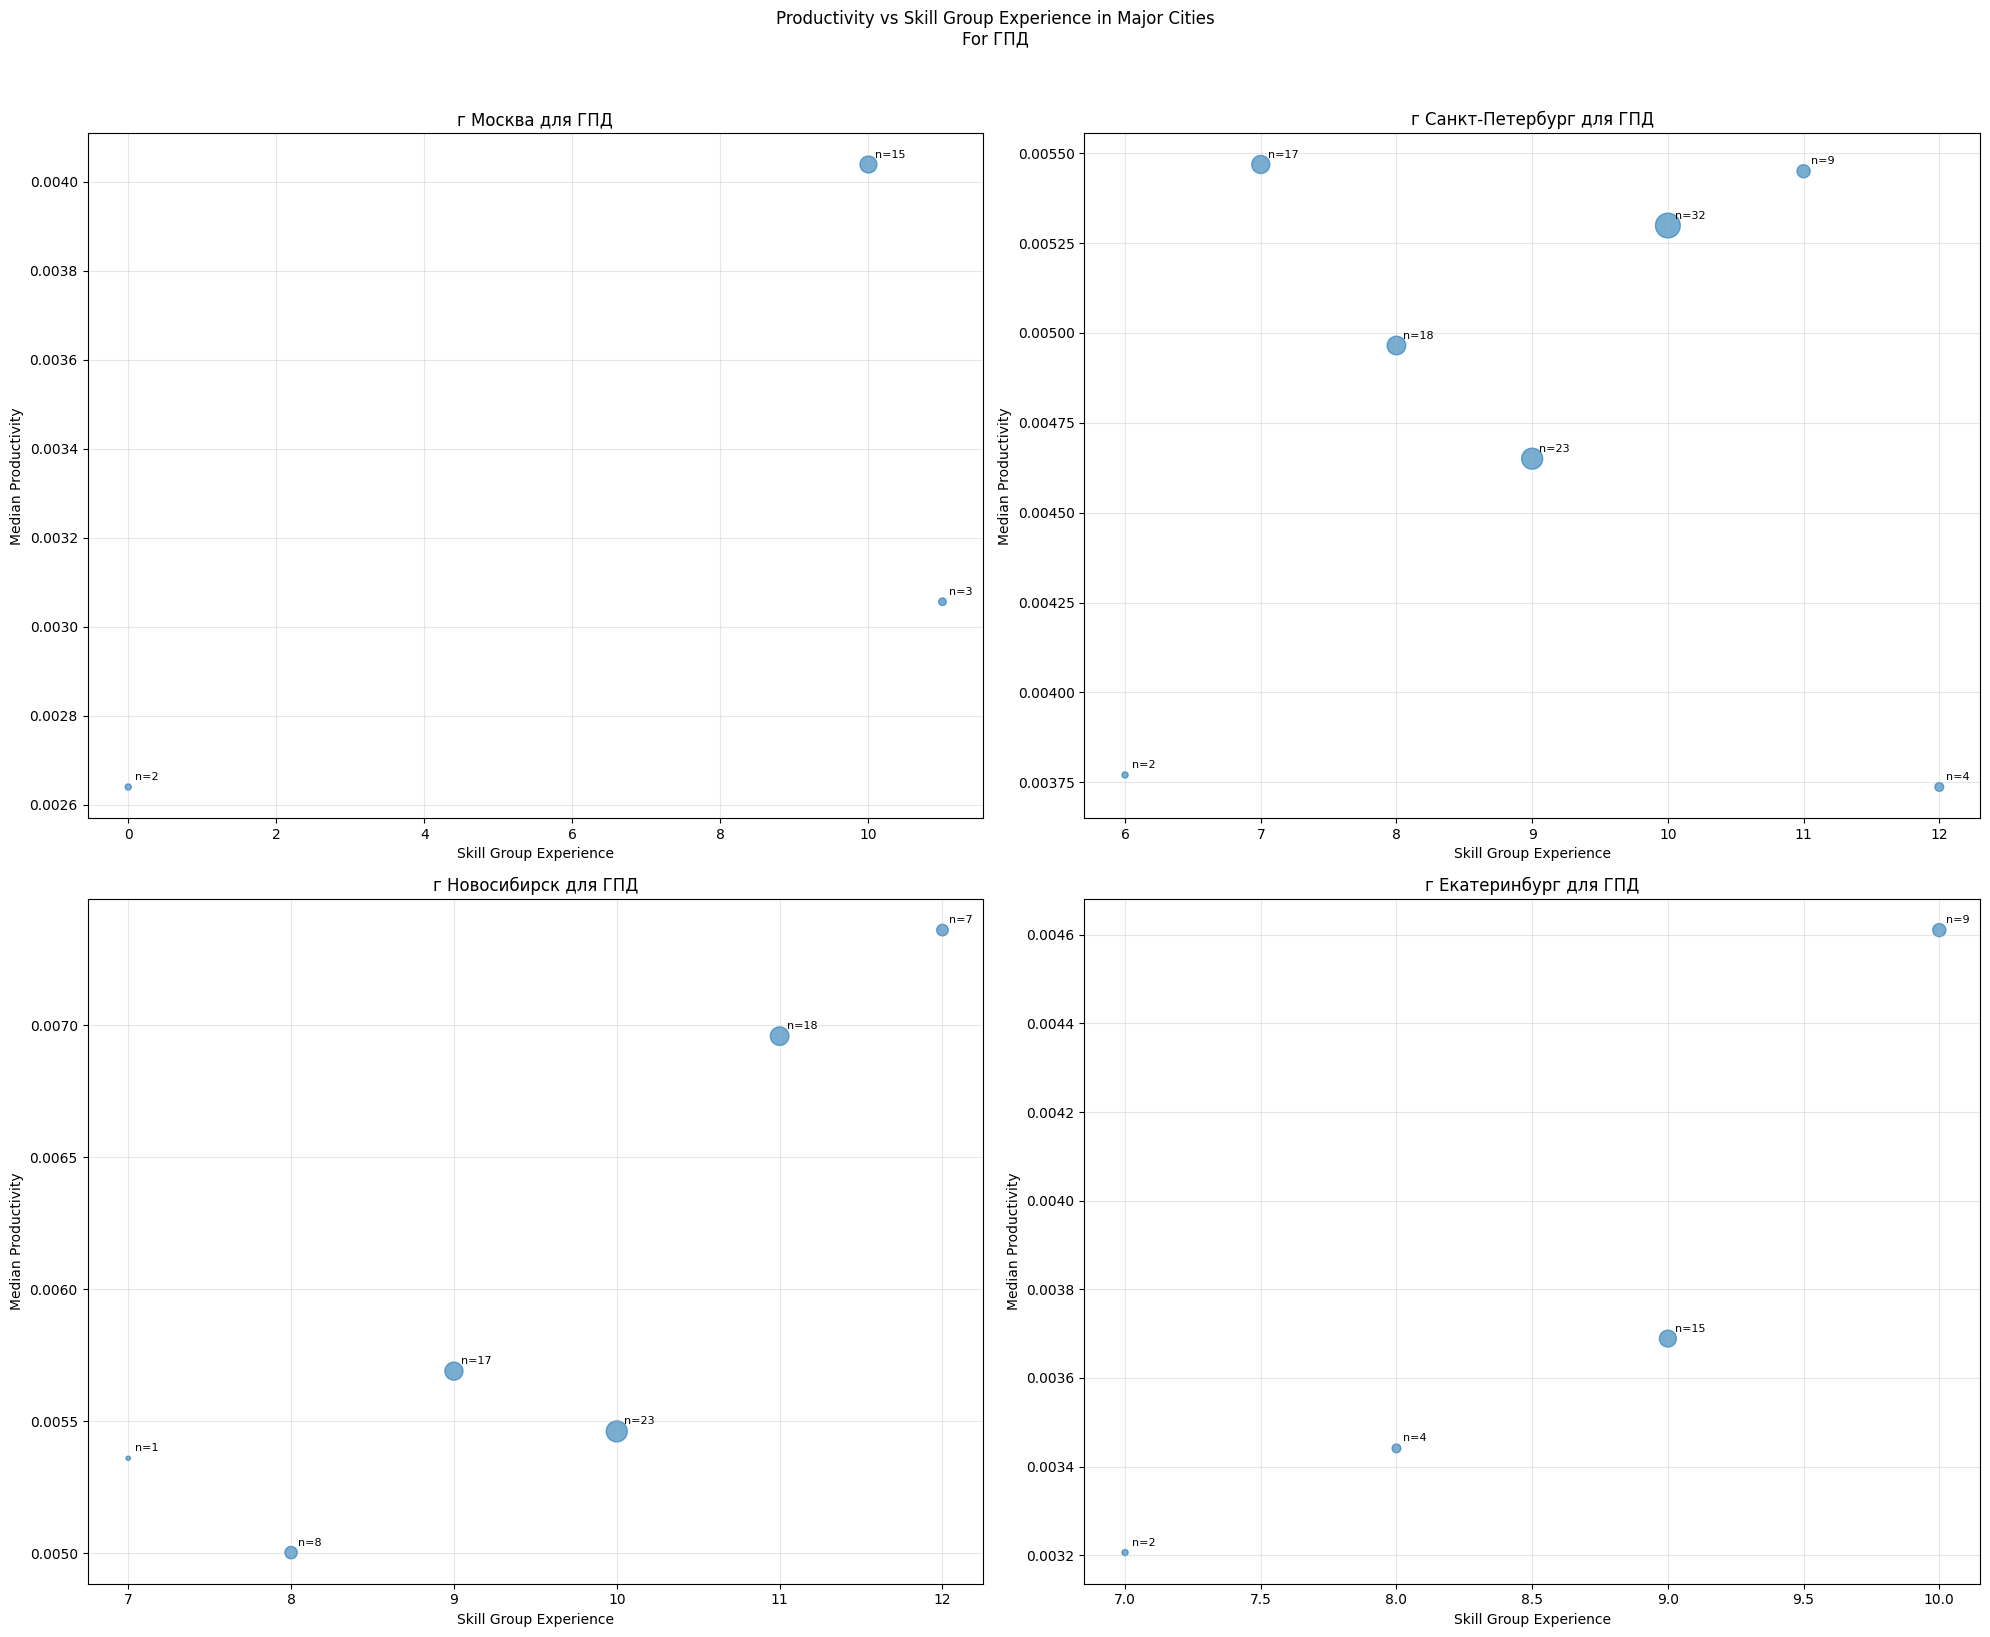

In [48]:
# Filter data
for i in ["ТК", "ПКЦ", "ГПД"]:
    filtered_data = df[df['emp_type'].isin([i])]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.ravel()
    
    for idx, city in enumerate(major_cities):
        # Filter data for each city
        city_data = filtered_data[filtered_data['residential_city_nm'] == city]
        city_grouped = city_data.groupby('skill_group_exp')['prod'].agg(['median', 'count']).reset_index()
        
        if len(city_grouped) > 0:  # Check if we have data
            # Create scatter plot
            axes[idx].scatter(city_grouped['skill_group_exp'],
                            city_grouped['median'],
                            s=city_grouped['count']*10,
                            alpha=0.6)
            
            # Add trend line if we have more than one point
            if len(city_grouped) > 1:
                z = np.polyfit(city_grouped['skill_group_exp'], city_grouped['median'], 1)
                p = np.poly1d(z)
                axes[idx].plot(city_grouped['skill_group_exp'],
                             p(city_grouped['skill_group_exp']),
                             "r--",
                             alpha=0.8)
            
            # Add annotations
            for _, row in city_grouped.iterrows():
                axes[idx].annotate(f'n={int(row["count"])}',
                                 (row['skill_group_exp'], row['median']),
                                 xytext=(5, 5),
                                 textcoords='offset points',
                                 fontsize=8)
        
        # Customize plot
        axes[idx].set_title(f'{city} для {i}')
        axes[idx].set_xlabel('Skill Group Experience')
        axes[idx].set_ylabel('Median Productivity')
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle(f'Productivity vs Skill Group Experience in Major Cities\nFor {i}', y=1.02)
    plt.tight_layout()
    plt.show()
